# Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting (AAAI'21 Best Paper)
--------------
이 실습은 Informer의 original github 코드를 기반으로 SageMaker에서 학습하는 방법을 가이드하고자 만들었습니다. 모든 라이선스는 [여기](https://github.com/zhouhaoyi/Informer2020) 구현된 원본 소스코드의 라이선스 정책을 따르고 있으며, [Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting](https://arxiv.org/abs/2012.07436) 논문에서 자세한 설명을 확인할 수 있습니다.

<p align="center">
<center><img src="./img/informer.png" height="90" width="450" alt=""><center>
<br><br>
<b>Figure 1.</b> The architecture of Informer.
</p>

## 1. 필요한 패키지 설치 및 업데이트

In [ ]:
install_needed = True  # should only be True once
# install_needed = False

In [ ]:
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
#     !{sys.executable} -m pip install -U split-folders tqdm albumentations crc32c wget
    !{sys.executable} -m pip install 'sagemaker[local]' --upgrade
    !{sys.executable} -m pip install -U bokeh smdebug sagemaker-experiments gdown
    !{sys.executable} -m pip install -U sagemaker torch torchvision
    !/bin/bash ./local/local_mode_setup.sh
    IPython.Application.instance().kernel.do_shutdown(True)

## 2. 환경 설정

Sagemaker 학습에 필요한 기본적인 package를 import 합니다. <br>
[boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)는 AWS 리소스와 동작하는 python 클래스를 제공하며, HTTP API 호출을 숨기는 추상화 모델입니다. boto3를 통해 python에서 Amazon EC2 인스턴스, S3 버켓과 같은 AWS 리소스와 동작할 수 있습니다.<br>
[sagemaker python sdk](https://sagemaker.readthedocs.io/en/stable/)는 Amazon SageMaker에서 기계 학습 모델을 교육 및 배포하기 위한 오픈 소스 라이브러리입니다.<br>

In [1]:
import joblib
import matplotlib.pyplot as plt
import sagemaker
# import splitfolders

import datetime
import glob
import os
import time
import warnings

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial

# import wget
# import tarfile
import shutil

import boto3
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision

# from tqdm import tqdm
from time import strftime
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

## 3. Experiments 관리

Amazon SageMaker에는 실험을 관리할 수 있는 [SageMaker Experiments](https://aws.amazon.com/ko/blogs/aws/amazon-sagemaker-experiments-organize-track-and-compare-your-machine-learning-trainings/) 서비스가 있습니다. 반복적인 실험에 대해 로깅을 남기기 위한 실험 이름 (create_experiment)과 trial (create_trial) 이름을 설정하는 함수입니다. <br> 이러한 메타 정보를 이용하여 향후 ML의 실험 관리가 용이해 질 수 있습니다.

In [2]:
def create_experiment(experiment_name):
    try:
        sm_experiment = Experiment.load(experiment_name)
    except:
        sm_experiment = Experiment.create(experiment_name=experiment_name,
                                          tags=[
                                              {
                                                  'Key': 'modelname',
                                                  'Value': 'informer'
                                              },
                                          ])

In [3]:
def create_trial(experiment_name, set_param, i_type, i_cnt, spot):
    create_date = strftime("%m%d-%H%M%s")
    
    algo = 'dp'
    
    spot = 's' if spot else 'd'
    i_tag = 'test'
    if i_type == 'ml.p3.16xlarge':
        i_tag = 'p3'
    elif i_type == 'ml.p3dn.24xlarge':
        i_tag = 'p3dn'
    elif i_type == 'ml.p4d.24xlarge':
        i_tag = 'p4d'    
        
    trial = "-".join([i_tag,str(i_cnt),algo, spot])
       
    sm_trial = Trial.create(trial_name=f'{experiment_name}-{trial}-{create_date}',
                            experiment_name=experiment_name)

    job_name = f'{sm_trial.trial_name}'
    return job_name

## 4. 데이터 저장소와 학습 script 위치 설정
SageMaker에는 학습에 사용할 데이터 위치와 학습 코드의 위치를 설정합니다. 편의를 위해 default_bucket을 사용했으나, 실제 활용 시에는 이미 생성한 bucket을 활용하는 것도 가능합니다. 

In [4]:
prefix = 'ETDataset'

sess = boto3.Session()
sagemaker_session = sagemaker.Session()
sm = sess.client('sagemaker')
default_bucket = sagemaker_session.default_bucket()

s3_data_path = f's3://{default_bucket}/{prefix}'
source_dir = 'Informer2020'

## 5. 실험 데이터 가져오기

논문에서 사용한 ETT 데이터셋은 [ETDataset](https://github.com/zhouhaoyi/ETDataset)에서 다운로드할 수 있습니다. ETT 데이터의 데모 형태는 아래 figure에서 볼 수 있으며, 각 데이터셋의 input은 zero-mean normalized가 되어 있습니다.

<p align="center">
<img src="./img/data.png" height = "168" alt="" align=center />
<br><br>
<b>Figure 3.</b> An example of the ETT data.
</p>
데이터셋은 단기 주기적 패턴, 장기 주기적 패턴, 장기 추세 및 많은 불규칙한 패턴을 결합합니다. figure 3와 같이 전체적인 관점을 제시하며, 분명한 seasonal trend를 보여 줍니다. target은 'oil temperature'이며, 일부 단기적으로 국지적인 연속성을 유지합니다. 그러나 다른 변수(전력 부하)는 단기 일별 패턴(24시간마다)과 장기 주별 패턴(7일마다)을 표시합니다.

첫 번째 row는 헤더 정보이며, "날짜", "HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL" 및 "OT"를 포함합니다. 각 열 이름의 세부 의미는 표 1에 나와 있습니다.
</p>

| Field | date | HUFL | HULL | MUFL | MULL | LUFL | LULL | OT |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| Description | The recorded **date** |**H**igh **U**se**F**ul **L**oad | **H**igh **U**se**L**ess **L**oad | **M**iddle **U**se**F**ul **L**oad | **M**iddle **U**se**L**ess **L**oad | **L**ow **U**se**F**ul **L**oad | **L**ow **U**se**L**ess **L**oad | **O**il **T**emperature (target) |

<p align="center"><b>Table 1.</b> Description for each columm.</p>
아래는 AWS CLI 명령어를 활용하여 github에서 데이터셋을 받은 후 미리 지정한 S3 bucket으로 업로드를 하는 명령어 입니다.

In [5]:
if not os.path.exists(prefix):
    !git clone https://github.com/zhouhaoyi/ETDataset.git
        
!aws s3 sync ./ETDataset/ s3://{default_bucket}/{prefix}

upload: ETDataset/ETT-small/.ipynb_checkpoints/ETTh1_small-checkpoint.csv to s3://sagemaker-us-west-2-322537213286/ETDataset/ETT-small/.ipynb_checkpoints/ETTh1_small-checkpoint.csv


## 6. 실험 설정

학습 시 사용한 소스코드와 output 정보를 저장할 위치를 선정합니다. 이 값은 필수로 설정하지 않아도 됩니다.

In [6]:
code_location = f's3://{default_bucket}/sm_codes'
output_path = f's3://{default_bucket}/poc_informer/output' 
checkpoint_s3_bucket = f's3://{default_bucket}/checkpoints'

실험에서 표준 출력으로 보여지는 metrics 값을 정규 표현식을 이용하여 SageMaker에서 값을 capture할 수 있습니다. 이 값은 필수로 설정하지 않아도 됩니다.

In [7]:
metric_definitions = [
    {'Name': 'Epoch', 'Regex': 'Epoch: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?),'},
    {'Name': 'train_loss', 'Regex': 'Train Loss: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?),'},
    {'Name': 'valid_loss', 'Regex': 'Valid Loss: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?),'},
    {'Name': 'test_loss', 'Regex': 'Test Loss: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?),'},
]

다양한 실험 조건을 테스트하기 위해 hyperparameters로 argument 값들을 노트북에서 설정할 수 있으며, 이 값은 학습 스크립트에서 argument인 변수로 받아서 활용이 가능합니다.

In [10]:
hyperparameters = {
        'model' : 'informer', # model of experiment, options: [informer, informerstack, informerlight(TBD)]
        'data' : 'ETTh1', # data
        'root_path' : 'ETT-small/', # root path of data file
        'data_path' : 'ETTh1.csv', # data file
        'features' : 'M', # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
        'target' : 'OT', # target feature in S or MS task
        'freq' : 'h', # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
        'checkpoints' : 'informer_checkpoints', # location of model checkpoints

        'seq_len' : 96, # input sequence length of Informer encoder
        'label_len' : 48, # start token length of Informer decoder
        'pred_len' : 24, # prediction sequence length
        # Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

        'enc_in' : 7, # encoder input size
        'dec_in' : 7, # decoder input size
        'c_out' : 7, # output size
        'factor' : 5, # probsparse attn factor
        'd_model' : 512, # dimension of model
        'n_heads' : 8, # num of heads
        'e_layers' : 2, # num of encoder layers
        'd_layers' : 1, # num of decoder layers
        'd_ff' : 2048, # dimension of fcn in model
        'dropout' : 0.05, # dropout
        'attn' : 'prob', # attention used in encoder, options:[prob, full]
        'embed' : 'timeF', # time features encoding, options:[timeF, fixed, learned]
        'activation' : 'gelu', # activation
        'distil' : True, # whether to use distilling in encoder
        'output_attention' : False, # whether to output attention in ecoder
        'mix' : True,
        'padding' : 0,
        'freq' : 'h',
        'do_predict' : True,
        'batch_size' : 32,
        'learning_rate' : 0.0001,
        'loss' : 'mse',
        'lradj' : 'type1',
        'use_amp' : False, # whether to use automatic mixed precision training

        'num_workers' : 0,
        'itr' : 1,
        'train_epochs' : 1,  ## Training epochs
        'patience' : 3,
        'des' : 'exp',
        'use_multi_gpu' : True
    }

experiment_name = 'informer-poc-exp1'
instance_type = 'ml.p3.16xlarge'  # 'ml.p3.16xlarge', 'ml.p3dn.24xlarge', 'ml.p4d.24xlarge', 'local_gpu'
# instance_type = 'local_gpu'
# instance_type = 'ml.c5.4xlarge'
instance_count = 1
do_spot_training = True
max_wait = None
max_run = 3*60*60


분산학습과 spot 학습을 사용할지를 선정할 수 있습니다. <br>
분산학습의 경우 [SageMaker data parallel library](https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel.html)를 사용하고자 할 경우 distribution을 아래와 같이 설정한 후 사용할 수 있습니다. (학습 스크립트 일부 수정 필요) <br>
[spot 학습](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html)을 사용하고자 할 경우 학습 파라미터에 spot 파라미터를 True로 변경한 다음, 자원이 없을 때 대기하는 시간인 max_wait (초)를 설정해야 합니다.

In [11]:
image_uri = None
train_job_name = 'sagemaker'


train_job_name = 'informer-dist'
distribution = {}

if instance_type in ['ml.p3.16xlarge', 'ml.p3dn.24xlarge', 'ml.p4d.24xlarge', 'local_gpu']:
    distribution["smdistributed"]={ 
                        "dataparallel": {
                            "enabled": True
                        }
                }
else:
    distribution = None

if do_spot_training:
    max_wait = max_run

print("train_job_name : {} \ntrain_instance_type : {} \ntrain_instance_count : {} \nimage_uri : {} \ndistribution : {}".format(train_job_name, instance_type, instance_count, image_uri, distribution))    

train_job_name : informer-dist 
train_instance_type : ml.p3.16xlarge 
train_instance_count : 1 
image_uri : None 
distribution : {'smdistributed': {'dataparallel': {'enabled': True}}}


In [12]:
# if instance_type =='local_gpu':
#     from sagemaker.local import LocalSession
#     from pathlib import Path

#     sagemaker_session = LocalSession()
#     sagemaker_session.config = {'local': {'local_code': True}}
#     s3_data_path = 'file:///home/ec2-user/SageMaker/timeseries_practise/ETDataset/'
#     source_dir = f'{Path.cwd()}/Informer2020'
#     do_spot_training = False
#     checkpoint_s3_bucket=None
#     max_wait = None

## 7. 학습을 위한 Estimator 선언

AWS 서비스 활용 시 role (역할) 설정은 매우 중요합니다. 이 노트북에서 사용하는 role은 노트북과 training job을 실행할 때 사용하는 role이며, role을 이용하여 다양한 AWS 서비스에 대한 접근 권한을 설정할 수 있습니다.

In [13]:
role = get_execution_role()
role

'arn:aws:iam::322537213286:role/service-role/AmazonSageMaker-ExecutionRole-20210401T133000'

In [14]:
# all input configurations, parameters, and metrics specified in estimator 
# definition are automatically tracked
estimator = PyTorch(
    entry_point='main_informer.py',
    source_dir=source_dir,
    role=role,
    sagemaker_session=sagemaker_session,
    framework_version='1.8.1',
    py_version='py36',
    instance_count=,
    instance_type="ml.p4d.24xlarge",
    volume_size=256,
    code_location = code_location,
    output_path=output_path,
    hyperparameters=hyperparameters,
    distribution=distribution,
    metric_definitions=metric_definitions,
    max_run=max_run,
    checkpoint_s3_uri=checkpoint_s3_bucket,
    use_spot_instances=do_spot_training,  # spot instance 활용
    max_wait=max_wait
)

## 8. 학습 수행 - 시작

In [23]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name, hyperparameters, instance_type, instance_count, do_spot_training)

# Now associate the estimator with the Experiment and Trial
estimator.fit(
    inputs={'training': s3_data_path}, 
    job_name=job_name,
    experiment_config={
      'TrialName': job_name,
      'TrialComponentDisplayName': job_name,
    },
    wait=False,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: informer-poc-exp1-p3-1-dp-s-0925-04051632542710


In [24]:
job_name=estimator.latest_training_job.name

아래 명령어를 이용하여 시작된 학습에 대한 로그를 노트북에서 확인합니다. 이 로그는 CloudWatch에서도 확인이 가능합니다. <br> 
아래 명령어를 실행해도 학습이 시작되는 것이 아니며, 실행된 training job의 로그만 보는 것입니다.

In [25]:
sagemaker_session.logs_for_job(job_name=job_name, wait=True)

2021-09-25 04:05:13 Starting - Launching requested ML instances...ProfilerReport-1632542710: InProgress
.........
2021-09-25 04:07:15 Starting - Preparing the instances for training......
2021-09-25 04:08:16 Downloading - Downloading input data...
2021-09-25 04:08:36 Training - Downloading the training image........................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-09-25 04:12:32,414 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-09-25 04:12:32,493 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-09-25 04:12:35,528 sagemaker_pytorch_container.training INFO     Invoking SMDataParallel
2021-09-25 04:12:35,528 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-09-25 04:12:36,273 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 

## 9. 학습 결과 확인

학습이 완료된 다음 S3에 저장된 산출물을 확인합니다.<br> model 결과물은 model.tar.gz에 저장되어 있고, 이외 학습 중 로그, 결과 산출물 등은 output.tar.gz에 저장할 수 있습니다.

In [26]:
artifacts_dir = estimator.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-us-west-2-322537213286/poc_informer/output/informer-poc-exp1-p3-1-dp-s-0925-04051632542710/output/
2021-09-25 04:14:16   63.2 MiB model.tar.gz


<br> S3에 저장된 학습 결과 산출물을 모두 노트북에 다운로드 받은 다음, 압축을 풉니다.

In [27]:
model_dir = './model'

!rm -rf $model_dir

import json , os

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

!aws s3 cp {artifacts_dir}model.tar.gz {model_dir}/model.tar.gz
!tar -xvzf {model_dir}/model.tar.gz -C {model_dir}

download: s3://sagemaker-us-west-2-322537213286/poc_informer/output/informer-poc-exp1-p3-1-dp-s-0925-04051632542710/output/model.tar.gz to model/model.tar.gz
predictor.py
README.md
requirements.txt
informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtFalse_mxFalse_exp_0/
informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtFalse_mxFalse_exp_0/checkpoint.pth
exp/
exp/__init__.py
exp/__pycache__/
exp/__pycache__/exp_basic.cpython-36.pyc
exp/__pycache__/__init__.cpython-36.pyc
exp/__pycache__/exp_informer.cpython-36.pyc
exp/exp_informer.py
exp/.ipynb_checkpoints/
exp/.ipynb_checkpoints/exp_informer-checkpoint.py
exp/.ipynb_checkpoints/exp_basic-checkpoint.py
exp/.ipynb_checkpoints/__init__-checkpoint.py
exp/exp_basic.py
postprocess.py
lambda/
lambda/create_model.py
lambda/.ipynb_checkpoints/
lambda/.ipynb_checkpoints/create_model-checkpoint.py
main_informer.py
LICENSE
__pycache__/
__pycache__/sm_dist.cpython-36.pyc
scripts/
scripts/ETT

## 10. 학습 결과의 Visualization

학습 스크립트에는 마지막 단계에 최종 학습된 모델을 이용하여 predict를 실행한 결과를 real_prediction.npy에 저장한 후 output.tar.gz로 압축하여 S3에 업로드 합니다. 이 결과를 다시 노트북에서 load한 후 plot하여 보여줍니다.

In [28]:
import numpy as np

setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtFalse_mxFalse_exp_0'

# the prediction will be saved in ./results/{setting}/real_prediction.npy
prediction = np.load(f'./model/results/{setting}/real_prediction.npy')
prediction.shape

(1, 24, 7)

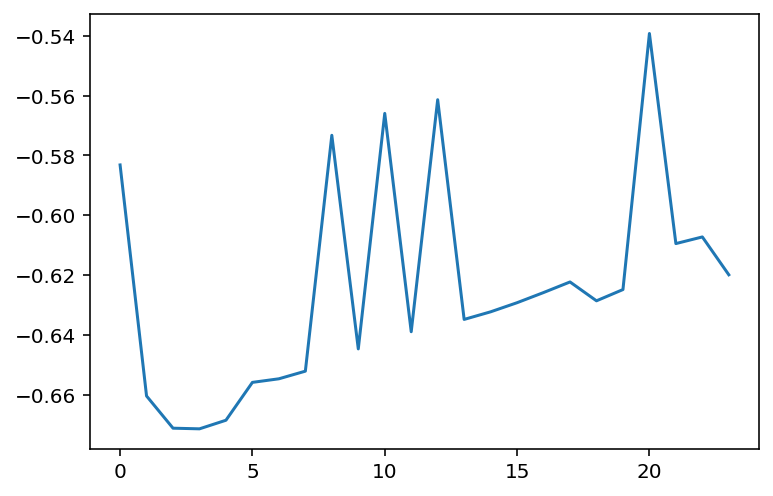

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

<br>
학습 스크립트에는 마지막 단계에 최종 학습된 모델을 이용하여 테스트 데이터에 대한 추론 결과를 pred.npy에, 실제 결과는 true.npy에 저장한 후 output.tar.gz로 압축하여 S3에 업로드 합니다. 이 결과를 다시 노트북에서 load한 후 plot하여 보여줍니다.

In [30]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load(f'./model/results/{setting}/pred.npy')
trues = np.load(f'./model/results/{setting}/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((2856, 24, 7), (2856, 24, 7))

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

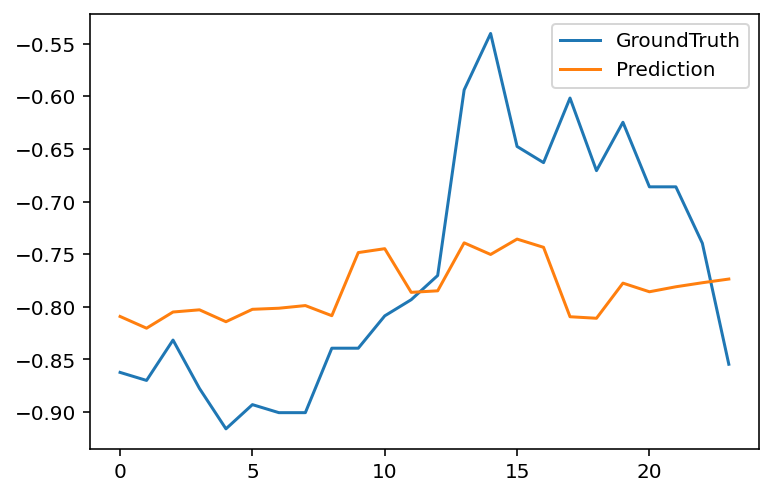

In [32]:
# draw OT (Oil Temperature) prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

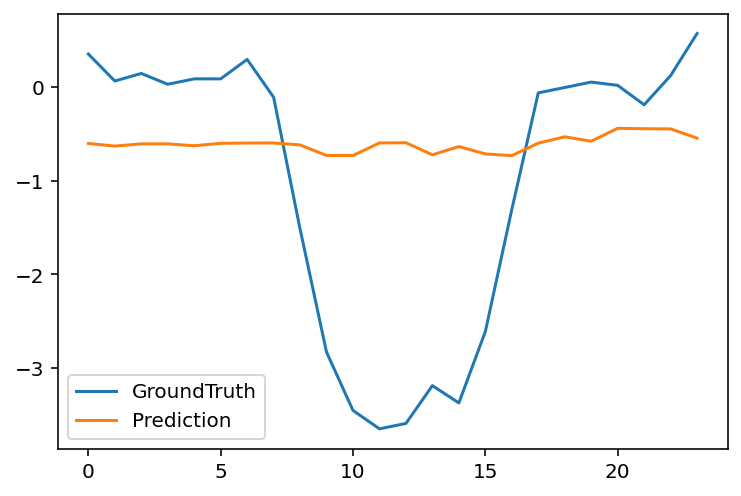

In [33]:
# draw HUFL (High UseFul Load) prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()